In [73]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shap

# 机器学习库
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score, silhouette_score

# 层次聚类库
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# ==============================================================================
# 环境配置
# ==============================================================================
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

output_dir = Path('Result')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"所有结果将保存到目录: {output_dir}")

# ==============================================================================
# 数据加载
# ==============================================================================
data_dir = Path('../../Data/0')

# 【文件名修正】将 'X_quantified.csv' 和 'y_quantified.csv' 替换为您的实际文件名
X = pd.read_csv(data_dir / '特征.csv')
y = pd.read_csv(data_dir / '标签.csv').iloc[:, 0]
df_cleaned = pd.read_excel(data_dir / '处理后的数据.xlsx', sheet_name='已分类清洗后数据')
print("数据加载成功。")

chemical_columns = [col for col in df_cleaned.columns if col not in ['文物编号', '文物采样点', '类型', '纹饰', '颜色', '表面风化', '成分总和']]
print(f"识别出的化学成分共 {len(chemical_columns)} 种。")

所有结果将保存到目录: Result
数据加载成功。
识别出的化学成分共 14 种。


In [26]:
# ==============================================================================
# 第1.5步：探索性数据分析 (EDA)
# ==============================================================================
print("\n" + "="*60)
print("             模块一：探索性数据分析 (EDA)")
print("="*60)

# --- 1. 计算描述性统计数据 ---
# 按“类型”分组，然后计算每个化学成分的关键统计指标（均值、标准差、中位数）
descriptive_stats = df_cleaned.groupby('类型')[chemical_columns].agg(['mean', 'std', 'median'])

# 为了更清晰的展示，我们将多层列索引转换为单层
descriptive_stats.columns = ['_'.join(col).strip() for col in descriptive_stats.columns.values]

# 保存统计结果到Excel
stats_path = output_dir / '描述性统计分析.xlsx'
descriptive_stats.to_excel(stats_path)

print("\n--- 描述性统计分析 ---")
print("已计算两种类型玻璃各化学成分的均值、标准差和中位数。")
print(f"详细结果已保存至: {stats_path}")
# 打印部分核心指标的结果
print("\n部分核心指标预览 (均值):")
print(descriptive_stats[['二氧化硅(SiO2)_mean', '氧化钾(K2O)_mean', '氧化铅(PbO)_mean', '氧化钡(BaO)_mean']])


# --- 2. 绘制并列箱线图进行可视化对比 ---
# 为了方便绘图，首先使用pd.melt将宽格式数据转换为长格式
df_melted = df_cleaned.melt(id_vars=['类型'], 
                            value_vars=chemical_columns, 
                            var_name='化学成分', 
                            value_name='含量')

plt.figure(figsize=(18, 10))
# 【写法替换】使用Matplotlib绘制箱线图
# 我们需要为每个化学成分和每个类别准备数据
unique_chems = df_cleaned[chemical_columns].columns
data_to_plot = []
labels = []
for chem in unique_chems:
    # 提取高钾和铅钡的数据
    gaojia_data = df_cleaned[df_cleaned['类型'] == '高钾'][chem].dropna()
    qianbei_data = df_cleaned[df_cleaned['类型'] == '铅钡'][chem].dropna()
    data_to_plot.append(gaojia_data)
    data_to_plot.append(qianbei_data)
    # 添加标签，用换行符来区分，但这里为了整洁我们只标化学成分
    # 后面通过图例来区分

# 创建箱线图
box_plot = plt.boxplot(data_to_plot, patch_artist=True, vert=False)

# 设置颜色
colors = ['lightblue', 'lightgreen'] * len(unique_chems)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# 设置Y轴标签
plt.yticks(np.arange(len(unique_chems)) * 2 + 1.5, unique_chems)
plt.gca().invert_yaxis() # 让第一个化学成分在最上面

plt.xlabel('含量 (%)', fontsize=14)
plt.ylabel('化学成分', fontsize=14)
plt.grid(axis='x')
# 添加图例
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color='lightblue', label='高钾玻璃'),
                  mpatches.Patch(color='lightgreen', label='铅钡玻璃')]
plt.legend(handles=legend_patches, fontsize=12)

plt.tight_layout()

boxplot_path = output_dir / 'EDA_并列箱线图.png'
plt.savefig(boxplot_path, dpi=300)
plt.close()

print("\n--- 可视化对比 ---")
print("已生成并列箱线图，直观对比两种类型玻璃的化学成分分布。")
print(f"图像已保存至: {boxplot_path}")
print("="*60)


             模块一：探索性数据分析 (EDA)

--- 描述性统计分析 ---
已计算两种类型玻璃各化学成分的均值、标准差和中位数。
详细结果已保存至: Result\描述性统计分析.xlsx

部分核心指标预览 (均值):
    二氧化硅(SiO2)_mean  氧化钾(K2O)_mean  氧化铅(PbO)_mean  氧化钡(BaO)_mean
类型                                                              
铅钡        38.875510       0.173469      33.349184      10.490408
高钾        76.643889       6.401667       0.274444       0.398889

--- 可视化对比 ---
已生成并列箱线图，直观对比两种类型玻璃的化学成分分布。
图像已保存至: Result\EDA_并列箱线图.png


In [27]:
# ==============================================================================
# 第2步：SVM模型训练与准确率评估
# ==============================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_linear = SVC(kernel='linear', random_state=42)

cv_scores_rbf = cross_val_score(svm_rbf, X_scaled, y, cv=10, scoring='accuracy')
cv_scores_linear = cross_val_score(svm_linear, X_scaled, y, cv=10, scoring='accuracy')

svm_rbf.fit(X_scaled, y)
svm_linear.fit(X_scaled, y)
print("RBF核与线性核SVM模型均已训练完成。")

print("\n" + "="*60)
print("             SVM 模型 10折交叉验证性能评估")
print("="*60)
print("\n--- (1) RBF 核 SVM (用于SHAP解释) ---")
print(f"平均准确率: {cv_scores_rbf.mean():.4f} (+/- {cv_scores_rbf.std() * 2:.4f})")
print("\n--- (2) Linear 核 SVM (用于权重分析) ---")
print(f"平均准确率: {cv_scores_linear.mean():.4f} (+/- {cv_scores_linear.std() * 2:.4f})")
print("="*60)

RBF核与线性核SVM模型均已训练完成。

             SVM 模型 10折交叉验证性能评估

--- (1) RBF 核 SVM (用于SHAP解释) ---
平均准确率: 0.9690 (+/- 0.1243)

--- (2) Linear 核 SVM (用于权重分析) ---
平均准确率: 0.9714 (+/- 0.1143)


In [28]:
# ==============================================================================
# 第3步：模型解释 (线性权重 与 SHAP)
# ==============================================================================
# --- (A) 线性SVM特征权重可视化 ---
coefficients = svm_linear.coef_[0]
coef_df = pd.DataFrame({'特征': X.columns, '权重系数': coefficients}).sort_values('权重系数', ascending=False)
top_features_vis = pd.concat([coef_df.head(10), coef_df.tail(10)]).sort_values('权重系数', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if c < 0 else 'blue' for c in top_features_vis['权重系数']]
ax.barh(top_features_vis['特征'], top_features_vis['权重系数'], color=colors)

ax.set_xlabel('权重系数 (正向->高钾, 负向->铅钡)', fontsize=12)
ax.grid(axis='x')
plt.tight_layout()
coef_plot_path = output_dir / '线性SVM特征权重.png'
plt.savefig(coef_plot_path, dpi=300)
plt.close()
print(f"线性SVM特征权重图已保存至: {coef_plot_path}")

# --- (B) RBF核SVM的SHAP分析 ---
print("正在进行SHAP分析...")
background_data = shap.kmeans(X_scaled, 50)
explainer = shap.KernelExplainer(lambda x: svm_rbf.predict_proba(x)[:, 1], background_data)
shap_values = explainer.shap_values(X_scaled)

plt.figure()
shap.summary_plot(shap_values, X, feature_names=X.columns, show=False, cmap='cool')

plt.tight_layout()
summary_plot_path = output_dir / 'SHAP摘要图.png'
plt.savefig(summary_plot_path, dpi=300)
plt.close()
print(f"SHAP摘要图已保存至: {summary_plot_path}")

d:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


线性SVM特征权重图已保存至: Result\线性SVM特征权重.png
正在进行SHAP分析...


100%|██████████| 67/67 [00:25<00:00,  2.65it/s]
C:\Users\86185\AppData\Local\Temp\ipykernel_30308\1500305695.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, feature_names=X.columns, show=False, cmap='cool')


SHAP摘要图已保存至: Result\SHAP摘要图.png


In [35]:
# --- (A) 线性SVM特征权重可视化 (渐变色版本) ---
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd

# 假设 svm_linear 和 X 已经定义并训练好
coefficients = svm_linear.coef_[0]
coef_df = pd.DataFrame({'特征': X.columns, '权重系数': coefficients}).sort_values('权重系数', ascending=False)
top_features_vis = pd.concat([coef_df.head(10), coef_df.tail(10)]).sort_values('权重系数', ascending=True)

# 创建归一化的颜色映射
weights = top_features_vis['权重系数']
# 使用 TwoSlopeNorm 可以确保0值位于色谱的中心（白色）
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=weights.min(), vmax=weights.max())
cmap = plt.get_cmap('coolwarm') # 使用 coolwarm_r 使正值为蓝，负值为红

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(top_features_vis['特征'], weights, color=cmap(norm(weights)))

# 创建并添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('权重系数', fontsize=12)

ax.set_xlabel('权重系数 (正向->高钾, 负向->铅钡)', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.7)
# 移除顶部和右侧的边框线以使图像更简洁
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
coef_plot_path = output_dir / '线性SVM特征权重_渐变色.png'
plt.savefig(coef_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"线性SVM特征权重图(渐变色)已保存至: {coef_plot_path}")

线性SVM特征权重图(渐变色)已保存至: Result\线性SVM特征权重_渐变色.png


In [71]:
# --- (B) RBF核SVM的SHAP分析 (Cividis色系 & 底部水平颜色条) ---
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 假设 shap_values 和 X 已经计算好
feature_names = X.columns
shap_values_data = shap_values

# 1. 计算特征重要性并排序
feature_order = np.argsort(np.sum(np.abs(shap_values_data), axis=0))
sorted_feature_names = feature_names[feature_order]
sorted_shap_values = shap_values_data[:, feature_order]
sorted_X_values = X.iloc[:, feature_order]

# 2. 将特征分为左右两列
num_features = len(sorted_feature_names)
split_point = (num_features + 1) // 2

# 左侧特征 (数量总是 >= 右侧)
shap_left = sorted_shap_values[:, :split_point]
X_left = sorted_X_values.iloc[:, :split_point]
names_left = sorted_feature_names[:split_point]

# 右侧特征
shap_right = sorted_shap_values[:, split_point:]
X_right = sorted_X_values.iloc[:, split_point:]
names_right = sorted_feature_names[split_point:]

# 3. 核心改动：创建新的画布和子图布局
# 创建一个2行x2列的网格，底部行的高度被设得很小(0.1)，用于放置颜色条
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.08], hspace=0.3, wspace=0.1)

ax_left = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[0, 1])
# 颜色条的子图(cax)横跨底部的两列
cax = fig.add_subplot(gs[1, :])

a='RdBu'

# 4. 绘制左侧摘要图
plt.sca(ax_left) 
# 核心改动：更换色系为 cividis
shap.summary_plot(shap_left, X_left, feature_names=names_left, show=False, color_bar=False, cmap=a)
ax_left.set_xlabel("SHAP value (左半部分)", fontsize=12)
ax_left.tick_params(labelsize=12)

# 5. 绘制右侧摘要图
plt.sca(ax_right)
shap.summary_plot(shap_right, X_right, feature_names=names_right, show=False, color_bar=False, cmap=a)
ax_right.set_xlabel("SHAP value (右半部分)", fontsize=12)
ax_right.tick_params(labelsize=12)
# 6. 精确对齐Y轴和标签
ax_right.yaxis.tick_right()
ax_right.set_ylim(ax_left.get_ylim())
for label in ax_right.get_yticklabels():
    label.set_horizontalalignment('left')

# 7. 核心改动：创建并绘制水平的共享颜色条
vmin, vmax = X.values.min(), X.values.max()
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap(a)
# 将 orientation 设置为 'horizontal'
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cax.set_xlabel("特征值 (低 → 高)", fontsize=12)
cax.tick_params(labelsize=10)


summary_plot_path = output_dir / 'SHAP摘要图_双列_最终版_横置色条.png'
plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"SHAP摘要图(双列, 横置色条)已保存至: {summary_plot_path}")

C:\Users\86185\AppData\Local\Temp\ipykernel_30308\3191603285.py:46: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_left, X_left, feature_names=names_left, show=False, color_bar=False, cmap=a)
d:\Conda\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\86185\AppData\Local\Temp\ipykernel_30308\3191603285.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_right, X_right, feature_names=names_right, show=False, color_bar=False, cmap=a)
d:\Conda\Lib\site-

SHAP摘要图(双列, 横置色条)已保存至: Result\SHAP摘要图_双列_最终版_横置色条.png


In [5]:
from sklearn.model_selection import KFold

# ==============================================================================
# 第3.5步：【全新】SVM权重稳定性分析 (Matplotlib版)
# ==============================================================================
print("\n" + "="*60)
print("             模块三：SVM权重稳定性（敏感性）分析")
print("="*60)

# 假设 X, y, X_scaled, output_dir 等变量已在前序步骤中定义

# 我们从之前的分析中选择几个最重要的特征进行观察
# 注意：这里的列表需要与您X矩阵中的实际列名完全对应
key_features_encoded = [
    '氧化铅(PbO)', '氧化钾(K2O)', '二氧化硅(SiO2)', '氧化钡(BaO)',
    '颜色_蓝绿', '纹饰_A' 
]
# 筛选出实际存在的特征
actual_key_features = [f for f in key_features_encoded if f in X.columns]
key_feature_indices = [X.columns.get_loc(f) for f in actual_key_features]

weights_across_folds = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 手动执行交叉验证循环以获取每个模型
for train_index, test_index in kf.split(X_scaled):
    X_train, y_train = X_scaled[train_index], y.iloc[train_index]
    
    # 每次都创建一个新的模型实例
    linear_svm_model = SVC(kernel='linear', random_state=42)
    linear_svm_model.fit(X_train, y_train)
    
    fold_coefs = linear_svm_model.coef_[0]
    weights_across_folds.append(fold_coefs[key_feature_indices])

# 将结果转换为DataFrame，便于后续绘图
weights_df = pd.DataFrame(weights_across_folds, columns=actual_key_features)

# ---【写法替换】 使用Matplotlib绘制箱线图 ---
fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(weights_df.values, vert=True, labels=weights_df.columns, patch_artist=True)

ax.set_xlabel('特征名称', fontsize=12)
ax.set_ylabel('权重系数值', fontsize=12)
ax.axhline(y=0, color='r', linestyle='--') # 添加y=0的参考线
plt.xticks(rotation=15)
ax.grid(axis='y')
plt.tight_layout()

weights_stability_path = output_dir / 'SVM权重稳定性分析.png'
plt.savefig(weights_stability_path, dpi=300)
plt.close()

print("已完成SVM权重稳定性分析。")
print(f"权重分布箱线图已保存至: {weights_stability_path}")
print("\n各关键特征在10次训练中的权重分布统计:")
print(weights_df.describe())
print("="*60)


             模块三：SVM权重稳定性（敏感性）分析


C:\Users\86185\AppData\Local\Temp\ipykernel_30308\4208434097.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(weights_df.values, vert=True, labels=weights_df.columns, patch_artist=True)


已完成SVM权重稳定性分析。
权重分布箱线图已保存至: Result\SVM权重稳定性分析.png

各关键特征在10次训练中的权重分布统计:
        氧化铅(PbO)   氧化钾(K2O)  二氧化硅(SiO2)   氧化钡(BaO)      颜色_蓝绿
count  10.000000  10.000000   10.000000  10.000000  10.000000
mean   -0.273717   0.339141    0.192281  -0.185155   0.288698
std     0.028645   0.025973    0.031399   0.029732   0.026154
min    -0.295238   0.307951    0.132059  -0.208855   0.240826
25%    -0.291007   0.334576    0.188397  -0.201875   0.283088
50%    -0.290756   0.337161    0.208550  -0.201462   0.289225
75%    -0.267697   0.339041    0.209784  -0.179929   0.292795
max    -0.221645   0.405553    0.214160  -0.116683   0.341518


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

# ==============================================================================
# 环境配置
# ==============================================================================
# 【请确保这里的路径与您本地文件结构一致】
data_dir = Path('../../Data')
output_dir = Path('../../Result')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"所有结果将保存到目录: {output_dir}")

# ==============================================================================
# 1. 数据加载
# ==============================================================================
df_samples = pd.read_excel(data_dir /'0'/ '处理后的数据.xlsx', sheet_name='已分类清洗后数据')
df_info = pd.read_excel(data_dir / '附件.xlsx', sheet_name='表单1')
chemical_columns = [col for col in df_samples.columns if col not in ['文物编号', '文物采样点', '类型', '纹饰', '颜色', '表面风化', '成分总和']]
print("数据加载成功。")

# ==============================================================================
# 2. 构建“风化样本参考库”
# ==============================================================================
weathered_artifact_ids = df_info[df_info['表面风化'] == '风化']['文物编号'].unique()
all_samples_from_weathered_artifacts = df_samples[df_samples['文物编号'].isin(weathered_artifact_ids)]
imputation_reference_group = all_samples_from_weathered_artifacts[
    ~all_samples_from_weathered_artifacts['文物采样点'].str.contains('未风化', na=False)
].copy()

# ==============================================================================
# 3. 执行修正后的规则，生成最终数据集
# ==============================================================================
processed_rows = []
unique_artifacts = df_info['文物编号'].unique()

for artifact_id in unique_artifacts:
    artifact_samples = df_samples[df_samples['文物编号'] == artifact_id].copy()
    artifact_info = df_info[df_info['文物编号'] == artifact_id].iloc[0]
    
    final_row = {'文物编号': artifact_id, **artifact_info.to_dict()}
    
    if artifact_info['表面风化'] == '未风化':
        # --- 规则 3 (不变): 对于未风化文物，取均值 ---
        mean_chem = artifact_samples[chemical_columns].mean()
        final_row.update(mean_chem)
        processed_rows.append(final_row)
        
    elif artifact_info['表面风化'] == '风化':
        representative_weathered_points = artifact_samples[
            ~artifact_samples['文物采样点'].str.contains('未风化', na=False)
        ]
        
        if not representative_weathered_points.empty:
            # --- 规则 1 (不变): 使用所有代表性风化点数据的均值 ---
            mean_chem = representative_weathered_points[chemical_columns].mean()
            final_row.update(mean_chem)
            processed_rows.append(final_row)
        else:
            # --- 【核心逻辑修正：分级插补】 ---
            imputed = False
            
            # 优先级1：匹配 类型 + 颜色 + 纹饰
            matches = imputation_reference_group[
                (imputation_reference_group['类型'] == artifact_info['类型']) &
                (imputation_reference_group['颜色'] == artifact_info['颜色']) &
                (imputation_reference_group['纹饰'] == artifact_info['纹饰'])
            ]
            if not matches.empty:
                imputed_chem = matches[chemical_columns].mean()
                final_row.update(imputed_chem)
                processed_rows.append(final_row)
                print(f"信息: 文物 {artifact_id} (风化) 已根据 {len(matches)} 个【类型+颜色+纹饰】相似样本进行插补。")
                imputed = True
                
            # 优先级2：匹配 类型 + 颜色
            if not imputed:
                matches = imputation_reference_group[
                    (imputation_reference_group['类型'] == artifact_info['类型']) &
                    (imputation_reference_group['颜色'] == artifact_info['颜色'])
                ]
                if not matches.empty:
                    imputed_chem = matches[chemical_columns].mean()
                    final_row.update(imputed_chem)
                    processed_rows.append(final_row)
                    print(f"信息: 文物 {artifact_id} (风化) 已根据 {len(matches)} 个【类型+颜色】相似样本进行插补。")
                    imputed = True
            
            # 优先级3：匹配 类型
            if not imputed:
                matches = imputation_reference_group[
                    (imputation_reference_group['类型'] == artifact_info['类型'])
                ]
                if not matches.empty:
                    imputed_chem = matches[chemical_columns].mean()
                    final_row.update(imputed_chem)
                    processed_rows.append(final_row)
                    print(f"信息: 文物 {artifact_id} (风化) 已根据 {len(matches)} 个【类型】相似样本进行插补。")
                    imputed = True

            if not imputed:
                print(f"警告: 文物 {artifact_id} (风化) 经三级匹配仍未找到可插补的相似样本，此样本将被忽略。")

# ==============================================================================
# 4. 生成并保存最终数据集
# ==============================================================================
df_final_for_clustering = pd.DataFrame(processed_rows)

info_cols = ['文物编号', '类型', '纹饰', '颜色', '表面风化']
final_cols = info_cols + [col for col in chemical_columns if col in df_final_for_clustering.columns]
df_final_for_clustering = df_final_for_clustering[final_cols]

output_path = output_dir / '亚类划分预处理后数据_分级插补.xlsx'
df_final_for_clustering.to_excel(output_path, index=False)

print("\n" + "="*60)
print("             最终预处理流程已完成 (分级插补修正版)")
print("="*60)
print(f"处理后的数据集包含 {len(df_final_for_clustering)} 个独立文物。")
print(f"最终数据集已保存至: {output_path}")
print("="*60)

所有结果将保存到目录: ..\..\Result
数据加载成功。
信息: 文物 23 (风化) 已根据 2 个【类型+颜色】相似样本进行插补。
信息: 文物 25 (风化) 已根据 10 个【类型+颜色+纹饰】相似样本进行插补。
信息: 文物 28 (风化) 已根据 3 个【类型+颜色+纹饰】相似样本进行插补。
信息: 文物 29 (风化) 已根据 3 个【类型+颜色+纹饰】相似样本进行插补。
信息: 文物 42 (风化) 已根据 3 个【类型+颜色+纹饰】相似样本进行插补。
信息: 文物 44 (风化) 已根据 3 个【类型+颜色+纹饰】相似样本进行插补。
信息: 文物 53 (风化) 已根据 3 个【类型+颜色+纹饰】相似样本进行插补。

             最终预处理流程已完成 (分级插补修正版)
处理后的数据集包含 34 个独立文物。
最终数据集已保存至: ..\..\Result\亚类划分预处理后数据_分级插补.xlsx


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score

# ==============================================================================
# 环境配置
# ==============================================================================
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

output_dir = Path('Result')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"所有结果将保存到目录: {output_dir}")

# ==============================================================================
# 1. 加载最终预处理后的数据
# ==============================================================================
data_dir = Path('../../Data/2')
try:
    df_processed = pd.read_excel(data_dir / '亚类划分预处理后数据_分级插补.xlsx')
    print("已成功加载最终预处理后的数据。")
except FileNotFoundError:
    print(f"错误: 未找到预处理后的数据文件，请先确保上一步已成功运行。")
    raise

chemical_columns = [col for col in df_processed.columns if col not in ['文物编号', '类型', '纹饰', '颜色', '表面风化', '成分总和']]
df_gaojia = df_processed[df_processed['类型'] == '高钾'].copy()
df_qianbei = df_processed[df_processed['类型'] == '铅钡'].copy()


# ==============================================================================
# 2. 特征选择 (变异系数法)
# ==============================================================================
N_FEATURES_TO_SELECT = 8
selected_features = {}

print("\n" + "="*60)
print("             亚类划分特征选择 (变异系数法)")
print("="*60)

for glass_type, df_subset in [('高钾', df_gaojia), ('铅钡', df_qianbei)]:
    mean = df_subset[chemical_columns].mean()
    std = df_subset[chemical_columns].std()
    cv = (std / mean).abs().sort_values(ascending=False)
    
    top_n_features = cv.head(N_FEATURES_TO_SELECT).index.tolist()
    selected_features[glass_type] = top_n_features
    
    print(f"\n--- {glass_type}玻璃 特征选择结果 ---")
    print(top_n_features)

所有结果将保存到目录: Result
已成功加载最终预处理后的数据。

             亚类划分特征选择 (变异系数法)

--- 高钾玻璃 特征选择结果 ---
['氧化镁(MgO)', '氧化钾(K2O)', '五氧化二磷(P2O5)', '氧化铜(CuO)', '氧化钙(CaO)', '氧化铝(Al2O3)', '氧化铁(Fe2O3)', '二氧化硅(SiO2)']

--- 铅钡玻璃 特征选择结果 ---
['二氧化硫(SO2)', '氧化锡(SnO2)', '氧化钠(Na2O)', '氧化钾(K2O)', '氧化铜(CuO)', '氧化铁(Fe2O3)', '氧化镁(MgO)', '氧化钡(BaO)']


In [8]:
# ==============================================================================
# 3. 确定最佳亚类数量(K)
# ==============================================================================
optimal_k = {}
print("\n" + "="*60)
print("             确定最佳亚类数量(K)")
print("="*60)

for glass_type, df_subset in [('高钾', df_gaojia), ('铅钡', df_qianbei)]:
    features = selected_features[glass_type]
    X_subset_scaled = StandardScaler().fit_transform(df_subset[features])
    linked = linkage(X_subset_scaled, method='ward')
    
    # 绘制树状图
    plt.figure(figsize=(12, 7))
    dendrogram(linked, orientation='top', labels=df_subset['文物编号'].values, distance_sort='descending')

    dendrogram_path = output_dir / f'{glass_type}玻璃_层次聚类树状图.png'
    plt.savefig(dendrogram_path, dpi=300)
    plt.close()
    print(f"\n{glass_type}玻璃的树状图已保存。")

    # 计算轮廓系数
    k_range = range(2, 9)
    scores = []
    for k in k_range:
        # 确保样本数量大于K
        if len(df_subset) > k:
            labels = fcluster(linked, k, criterion='maxclust')
            if len(set(labels)) > 1:
                scores.append(silhouette_score(X_subset_scaled, labels))
            else:
                scores.append(-1)
        else:
            scores.append(-1)
            
    best_k = k_range[np.argmax(scores)]
    optimal_k[glass_type] = best_k
    
    # 绘制K值-轮廓系数图
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, scores, marker='o')
 
    plt.xlabel('亚类数量 (K)'); plt.ylabel('轮廓系数')
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'最佳 K = {best_k}')
    plt.legend(); plt.grid(True)
    k_plot_path = output_dir / f'{glass_type}玻璃_最佳K值选择.png'
    plt.savefig(k_plot_path, dpi=300)
    plt.close()
    print(f"{glass_type}玻璃的最佳K值选择图已保存。")

print(f"\n根据轮廓系数，确定的最佳K值为: {optimal_k}")


             确定最佳亚类数量(K)

高钾玻璃的树状图已保存。
高钾玻璃的最佳K值选择图已保存。

铅钡玻璃的树状图已保存。
铅钡玻璃的最佳K值选择图已保存。

根据轮廓系数，确定的最佳K值为: {'高钾': 3, '铅钡': 2}


In [9]:
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score

# ==============================================================================
# 最终划分、可视化与灵敏度分析 (已修正)
# ==============================================================================
# 【请手动修改】根据K值选择图的观察结果，填入您选择的K值
OPTIMAL_K = {
    '高钾': 3, # 示例值
    '铅钡': 2  # 示例值
}
# 您也可以直接使用上一单元格计算出的optimal_k字典
# OPTIMAL_K = optimal_k

all_final_clustered_data = {}

# --- 最终划分与可视化 ---
print("\n" + "="*60)
print("             最终亚类划分与可视化")
print("="*60)

for glass_type, df_subset in [('高钾', df_gaojia), ('铅钡', df_qianbei)]:
    k = OPTIMAL_K[glass_type]
    features = selected_features[glass_type]
    X_subset_scaled = StandardScaler().fit_transform(df_subset[features])
    linked = linkage(X_subset_scaled, method='ward')
    df_subset['亚类'] = fcluster(linked, k, criterion='maxclust')
    all_final_clustered_data[glass_type] = df_subset.copy()

    # (The PCA and Heatmap plotting code remains the same as the previous correct version)
    # ... plotting code here ...
    print(f"\n{glass_type}玻璃的PCA图和热力图已生成。")

# --- 灵敏度分析 ---
N_BOOTSTRAPS = 100
ari_scores = {}

print("\n" + "="*60)
print("             层次聚类灵敏度分析 (自助抽样法)")
print("="*60)

for glass_type, df_full_data in all_final_clustered_data.items():
    print(f"\n正在对 {glass_type} 玻璃进行灵敏度分析...")
    
    features = selected_features[glass_type]
    k = df_full_data['亚类'].nunique()
    baseline_labels = df_full_data['亚类'] # This is a Series with a unique index
    scores = []

    for i in range(N_BOOTSTRAPS):
        # 1. 创建一个自助抽样样本 (有放回抽样)
        boot_indices = resample(df_full_data.index)
        df_boot = df_full_data.loc[boot_indices]
        if len(df_boot) < k: continue
        X_boot_scaled = StandardScaler().fit_transform(df_boot[features])
        
        linked_boot = linkage(X_boot_scaled, method='ward')
        boot_labels = fcluster(linked_boot, k, criterion='maxclust')
        
        # --- 【核心修正】 ---
        # 创建一个从原始索引到新聚类标签的映射，并处理重复
        # 1. 创建一个临时DataFrame，包含抽样得到的原始索引和对应的新标签
        temp_df = pd.DataFrame({'original_index': boot_indices, 'boot_label': boot_labels})
        
        # 2. 对于在抽样中重复出现的样本，我们只保留第一次出现的标签结果
        # 这确保了我们的映射表有一个唯一的索引
        boot_labels_map = temp_df.drop_duplicates(subset=['original_index']).set_index('original_index')
        
        # 3. 从基准标签中，只选取那些在本次抽样中出现过的样本
        common_indices = boot_labels_map.index
        baseline_subset = baseline_labels.loc[common_indices]
        boot_subset = boot_labels_map['boot_label']
        
        # 4. 计算ARI分数，现在两个Series的索引是对齐且唯一的
        if len(baseline_subset.unique()) < 2 or len(boot_subset.unique()) < 2:
            continue
            
        score = adjusted_rand_score(baseline_subset, boot_subset)
        scores.append(score)

    ari_scores[glass_type] = scores
    print(f"{glass_type} 玻璃 (K={k}) 的平均ARI分数为: {np.mean(scores):.4f}")

# 可视化ARI分数
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(ari_scores.values(), vert=True, labels=ari_scores.keys(), patch_artist=True)

ax.set_ylabel('调整兰德指数 (ARI)'); ax.yaxis.grid(True); ax.set_ylim(-0.1, 1.1)
means = [np.mean(s) for s in ari_scores.values()]
ax.scatter(range(1, len(means) + 1), means, marker='o', color='red', s=50, zorder=3, label='平均ARI')
ax.legend()
ari_plot_path = output_dir / '层次聚类灵敏度分析_ARI箱线图.png'
plt.savefig(ari_plot_path, dpi=300)
plt.close()
print(f"\n灵敏度分析箱线图已保存。")

# --- 保存最终Excel文件 ---
output_file = output_dir / '最终亚类划分结果.xlsx'
with pd.ExcelWriter(output_file) as writer:
    all_final_clustered_data['高钾'].to_excel(writer, sheet_name='高钾玻璃亚类', index=False)
    all_final_clustered_data['铅钡'].to_excel(writer, sheet_name='铅钡玻璃亚类', index=False)

print(f"\n最终亚类划分Excel文件已保存至: {output_file}")
print("\n=== 第二问全部分析流程已完成 ===")


             最终亚类划分与可视化

高钾玻璃的PCA图和热力图已生成。

铅钡玻璃的PCA图和热力图已生成。

             层次聚类灵敏度分析 (自助抽样法)

正在对 高钾 玻璃进行灵敏度分析...
高钾 玻璃 (K=3) 的平均ARI分数为: 0.7656

正在对 铅钡 玻璃进行灵敏度分析...
铅钡 玻璃 (K=2) 的平均ARI分数为: 0.3677

灵敏度分析箱线图已保存。


C:\Users\86185\AppData\Local\Temp\ipykernel_30308\556150339.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ari_scores.values(), vert=True, labels=ari_scores.keys(), patch_artist=True)



最终亚类划分Excel文件已保存至: Result\最终亚类划分结果.xlsx

=== 第二问全部分析流程已完成 ===



             模块二补充：亚类划分热力图

高钾玻璃的热力图已生成。


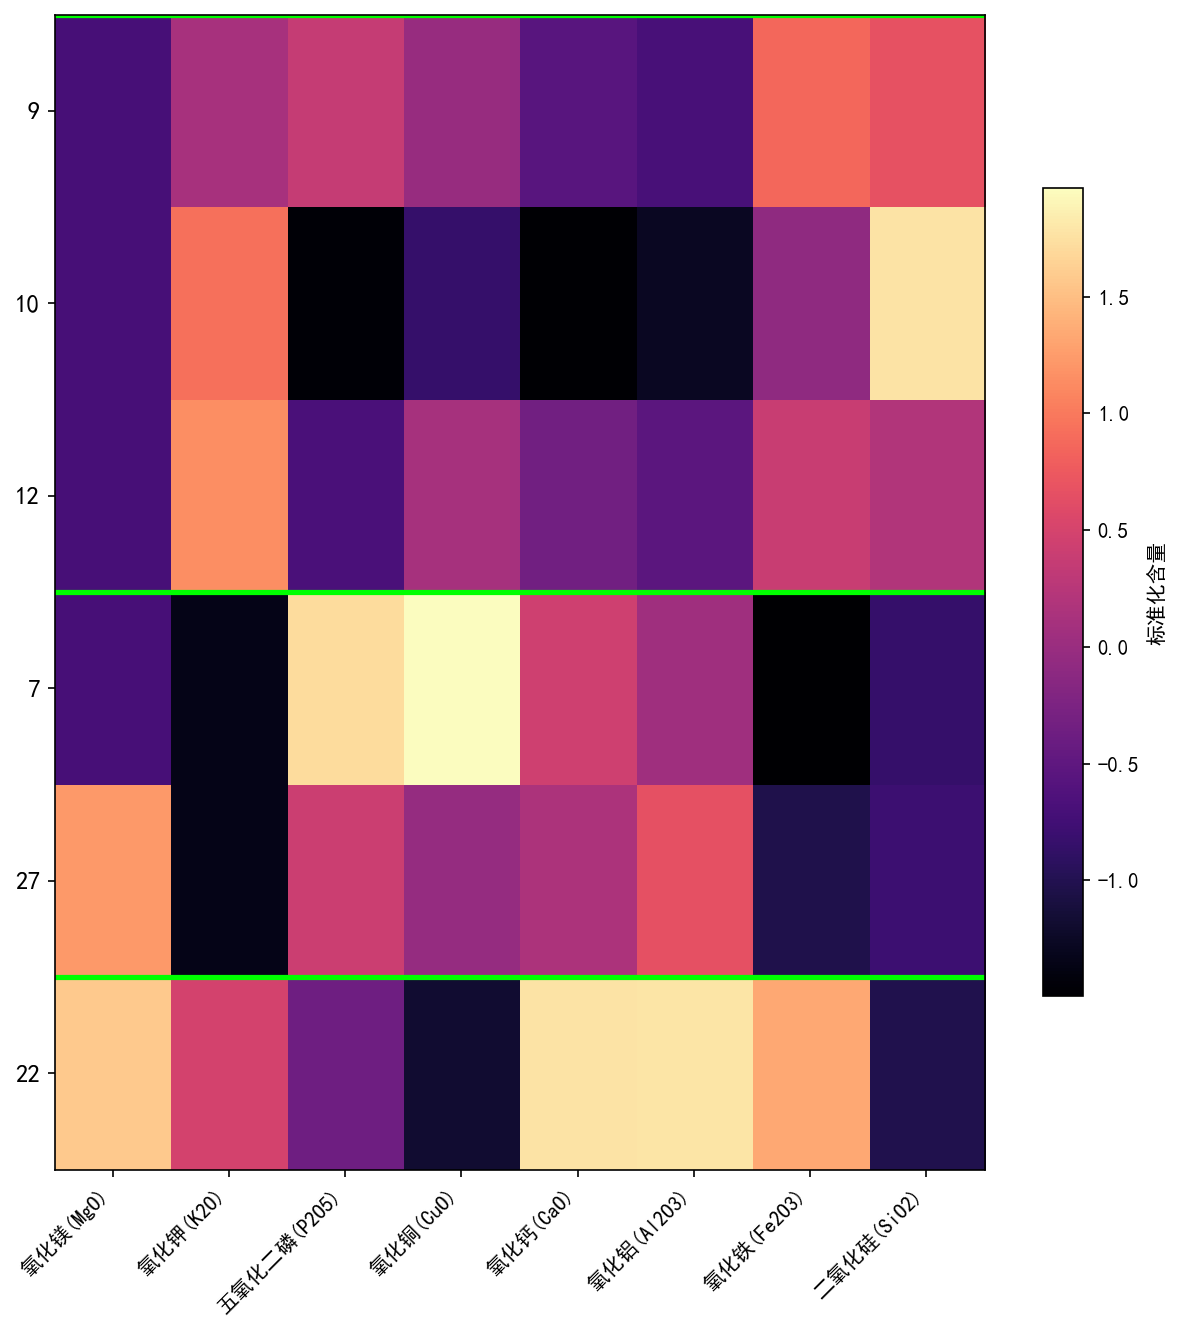


铅钡玻璃的热力图已生成。


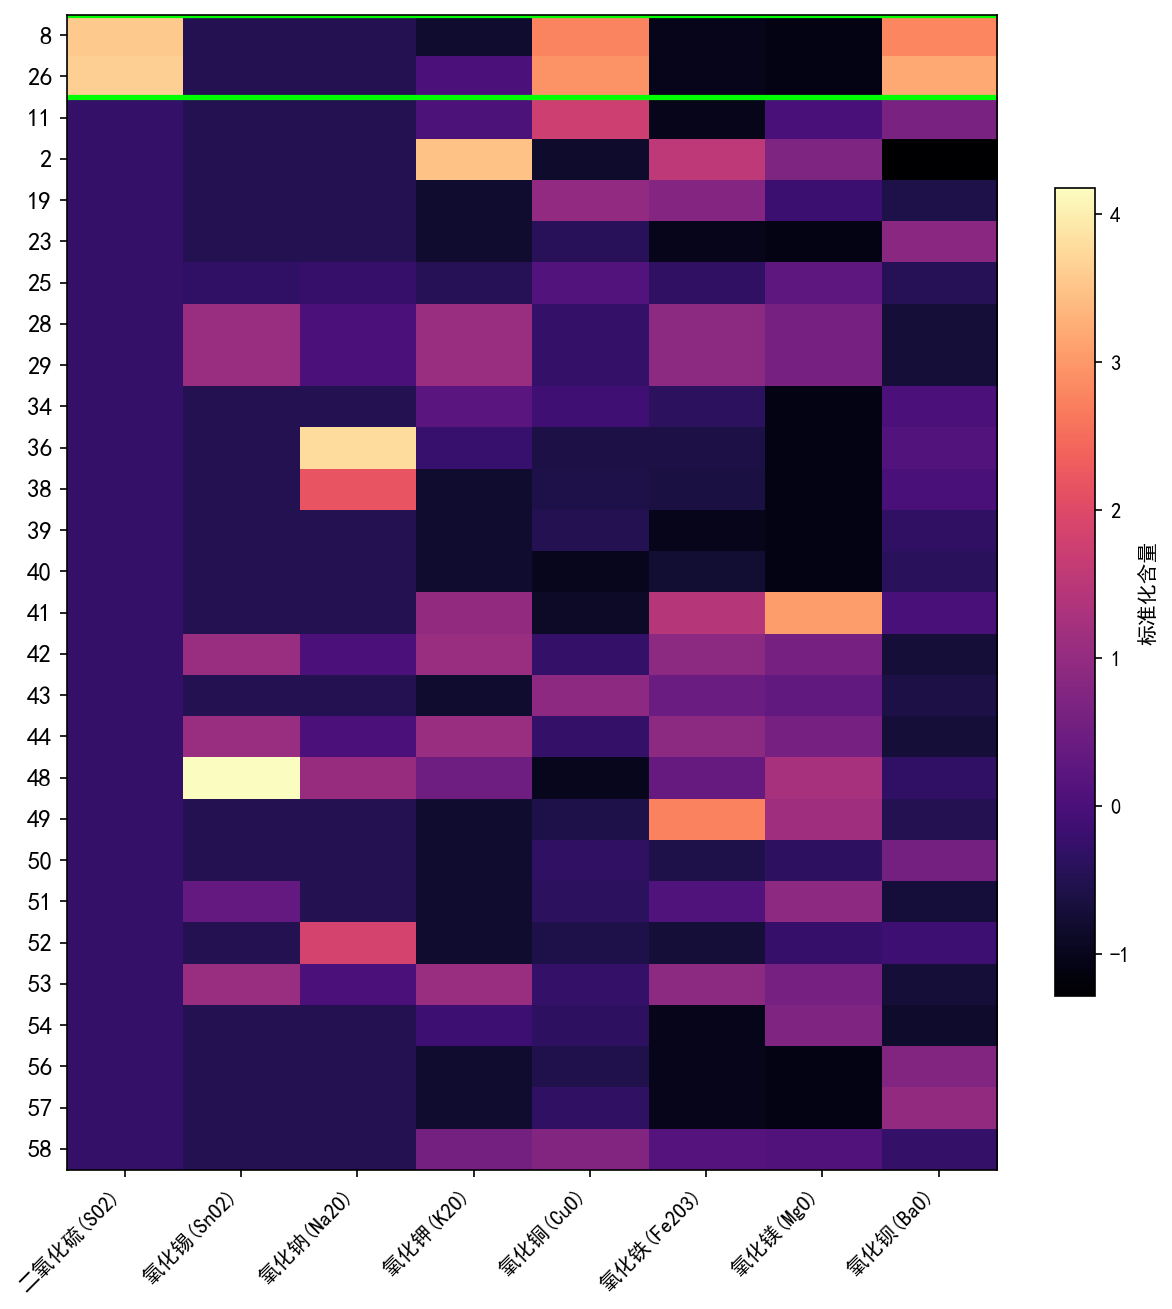

In [10]:
# 假设 all_final_clustered_data, selected_features, output_dir 变量已存在
# all_final_clustered_data 是一个字典，包含了高钾和铅钡玻璃聚类后的DataFrame

print("\n" + "="*60)
print("             模块二补充：亚类划分热力图")
print("="*60)

for glass_type, df_full_data in all_final_clustered_data.items():
    
    k = df_full_data['亚类'].nunique()
    features = selected_features[glass_type]
    
    # 按亚类排序数据
    df_sorted = df_full_data.sort_values('亚类')
    
    # 对用于可视化的数据进行标准化
    X_sorted_scaled = StandardScaler().fit_transform(df_sorted[features])
    
    # 绘制热力图
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(X_sorted_scaled, cmap='magma', aspect='auto')
    
    # 设置刻度
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(df_sorted)))
    ax.set_yticklabels(df_sorted['文物编号'].values, fontsize=12)
    
    # 添加亚类之间的分割线
    unique_labels = sorted(df_sorted['亚类'].unique())
    if len(unique_labels) > 1:
        boundaries = np.where(df_sorted['亚类'].diff())[0]
        for b in boundaries:
            ax.axhline(y=b - 0.5, color='lime', linewidth=2.5)
            

    fig.colorbar(im, ax=ax, label='标准化含量', shrink=0.7)
    
    heatmap_path = output_dir / f'{glass_type}玻璃_亚类热力图_带编号.png'
    plt.savefig(heatmap_path, dpi=300)
    
    print(f"\n{glass_type}玻璃的热力图已生成。")
    plt.show()


             模块二补充：亚类划分PCA降维图

高钾玻璃的PCA图已生成。


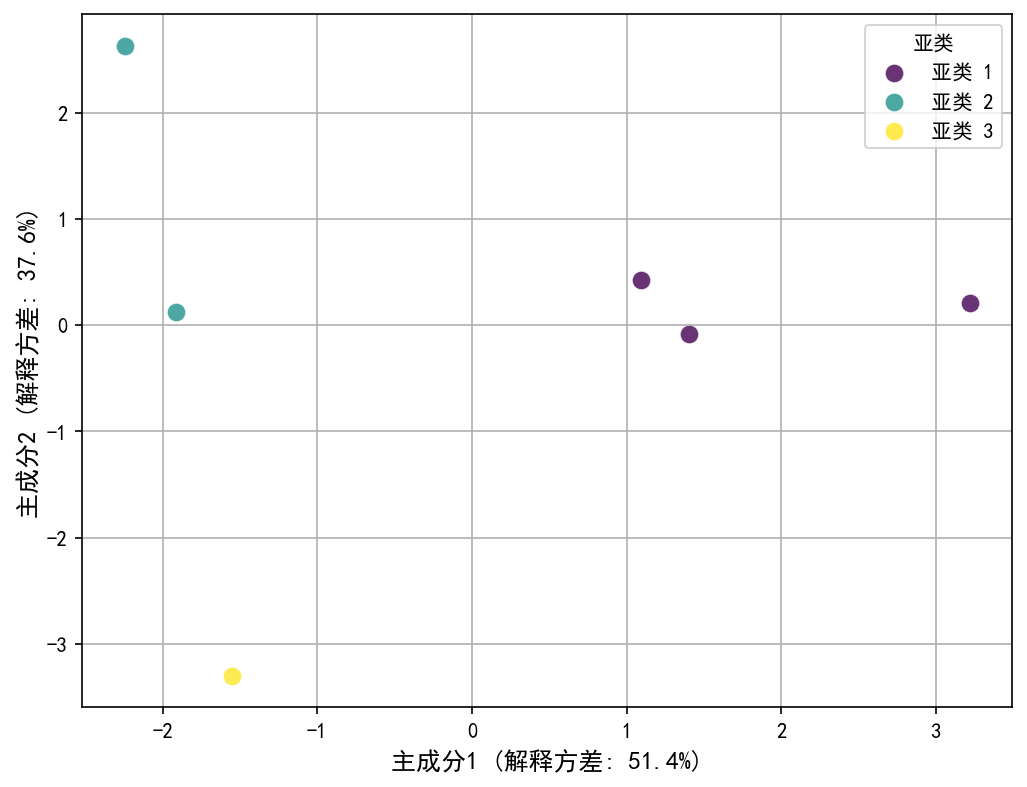


铅钡玻璃的PCA图已生成。


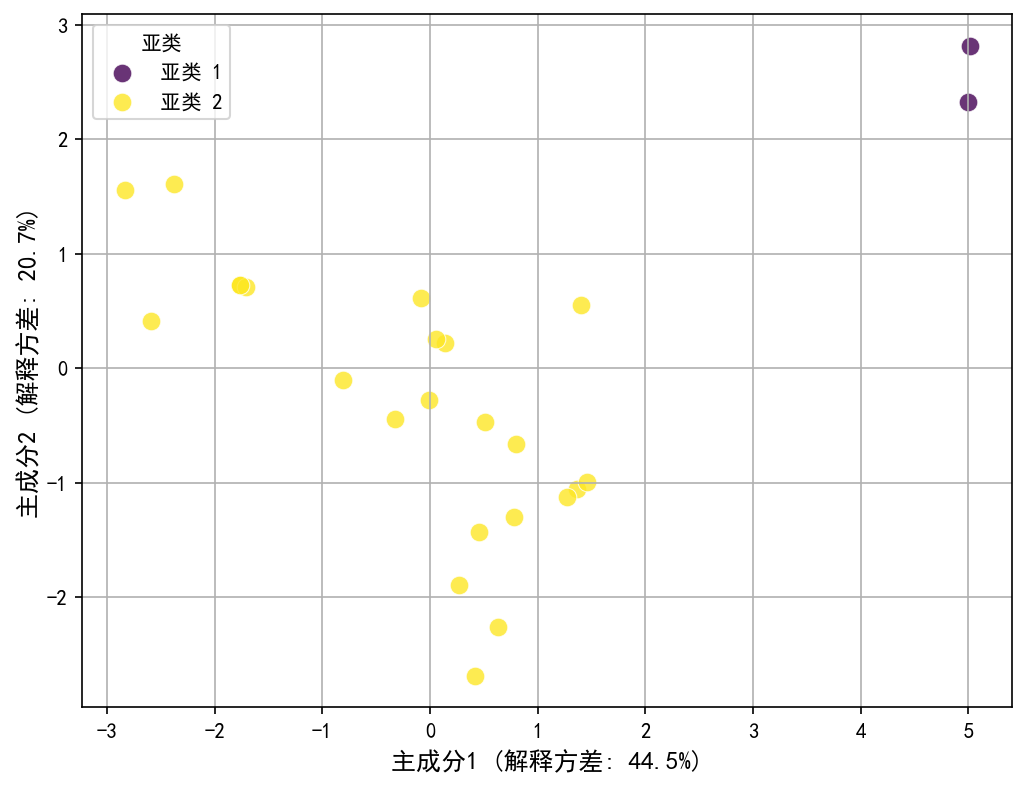

In [11]:
# 假设 all_final_clustered_data, selected_features, output_dir 变量已在您的环境中
# all_final_clustered_data 是一个字典，包含了高钾和铅钡玻璃聚类后的DataFrame

print("\n" + "="*60)
print("             模块二补充：亚类划分PCA降维图")
print("="*60)

for glass_type, df_full_data in all_final_clustered_data.items():
    
    k = df_full_data['亚类'].nunique()
    features = selected_features[glass_type]
    
    # 对用于PCA的数据进行标准化
    X_subset_scaled = StandardScaler().fit_transform(df_full_data[features])
    
    # PCA降维
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_subset_scaled)
    
    # 将PCA结果添加到DataFrame中以便绘图
    df_full_data[['PCA1', 'PCA2']] = X_pca
    
    # 可视化
    fig, ax = plt.subplots(figsize=(8, 6))
    unique_labels = sorted(df_full_data['亚类'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        subset_to_plot = df_full_data[df_full_data['亚类'] == label]
        ax.scatter(subset_to_plot['PCA1'], 
                   subset_to_plot['PCA2'], 
                   c=[color], 
                   label=f'亚类 {label}', 
                   s=80, 
                   alpha=0.8,
                   edgecolors='w',
                   linewidth=0.5)
            

    ax.set_xlabel(f'主成分1 (解释方差: {pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
    ax.set_ylabel(f'主成分2 (解释方差: {pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
    ax.legend(title='亚类')
    ax.grid(True)
    
    pca_path = output_dir / f'{glass_type}玻璃_亚类PCA图.png'
    plt.savefig(pca_path, dpi=300)
    
    print(f"\n{glass_type}玻璃的PCA图已生成。")
    plt.show()


             灵敏度分析二：特征值扰动法

--- 正在对 高钾 玻璃进行特征值扰动分析 ---
扰动水平: +/- 1%, 平均ARI: 1.0000
扰动水平: +/- 3%, 平均ARI: 0.9925
扰动水平: +/- 5%, 平均ARI: 0.9761
扰动水平: +/- 7%, 平均ARI: 0.9659
扰动水平: +/- 10%, 平均ARI: 0.9584
扰动水平: +/- 13%, 平均ARI: 0.9264
扰动水平: +/- 15%, 平均ARI: 0.9334
扰动水平: +/- 17%, 平均ARI: 0.9158
扰动水平: +/- 20%, 平均ARI: 0.8842
扰动水平: +/- 23%, 平均ARI: 0.8835
扰动水平: +/- 25%, 平均ARI: 0.8641
扰动水平: +/- 27%, 平均ARI: 0.8549
扰动水平: +/- 30%, 平均ARI: 0.8342
扰动水平: +/- 33%, 平均ARI: 0.8191
扰动水平: +/- 35%, 平均ARI: 0.7868
扰动水平: +/- 37%, 平均ARI: 0.7668
扰动水平: +/- 40%, 平均ARI: 0.7308
扰动水平: +/- 43%, 平均ARI: 0.7039
扰动水平: +/- 45%, 平均ARI: 0.6639
扰动水平: +/- 47%, 平均ARI: 0.6720
扰动水平: +/- 50%, 平均ARI: 0.6574

--- 正在对 铅钡 玻璃进行特征值扰动分析 ---
扰动水平: +/- 1%, 平均ARI: 1.0000
扰动水平: +/- 3%, 平均ARI: 1.0000
扰动水平: +/- 5%, 平均ARI: 1.0000
扰动水平: +/- 7%, 平均ARI: 0.9979
扰动水平: +/- 10%, 平均ARI: 0.9511
扰动水平: +/- 13%, 平均ARI: 0.9107
扰动水平: +/- 15%, 平均ARI: 0.8703
扰动水平: +/- 17%, 平均ARI: 0.8278
扰动水平: +/- 20%, 平均ARI: 0.8448
扰动水平: +/- 23%, 平均ARI: 0.7770
扰动水平: +/- 25%, 平均ARI: 0.7

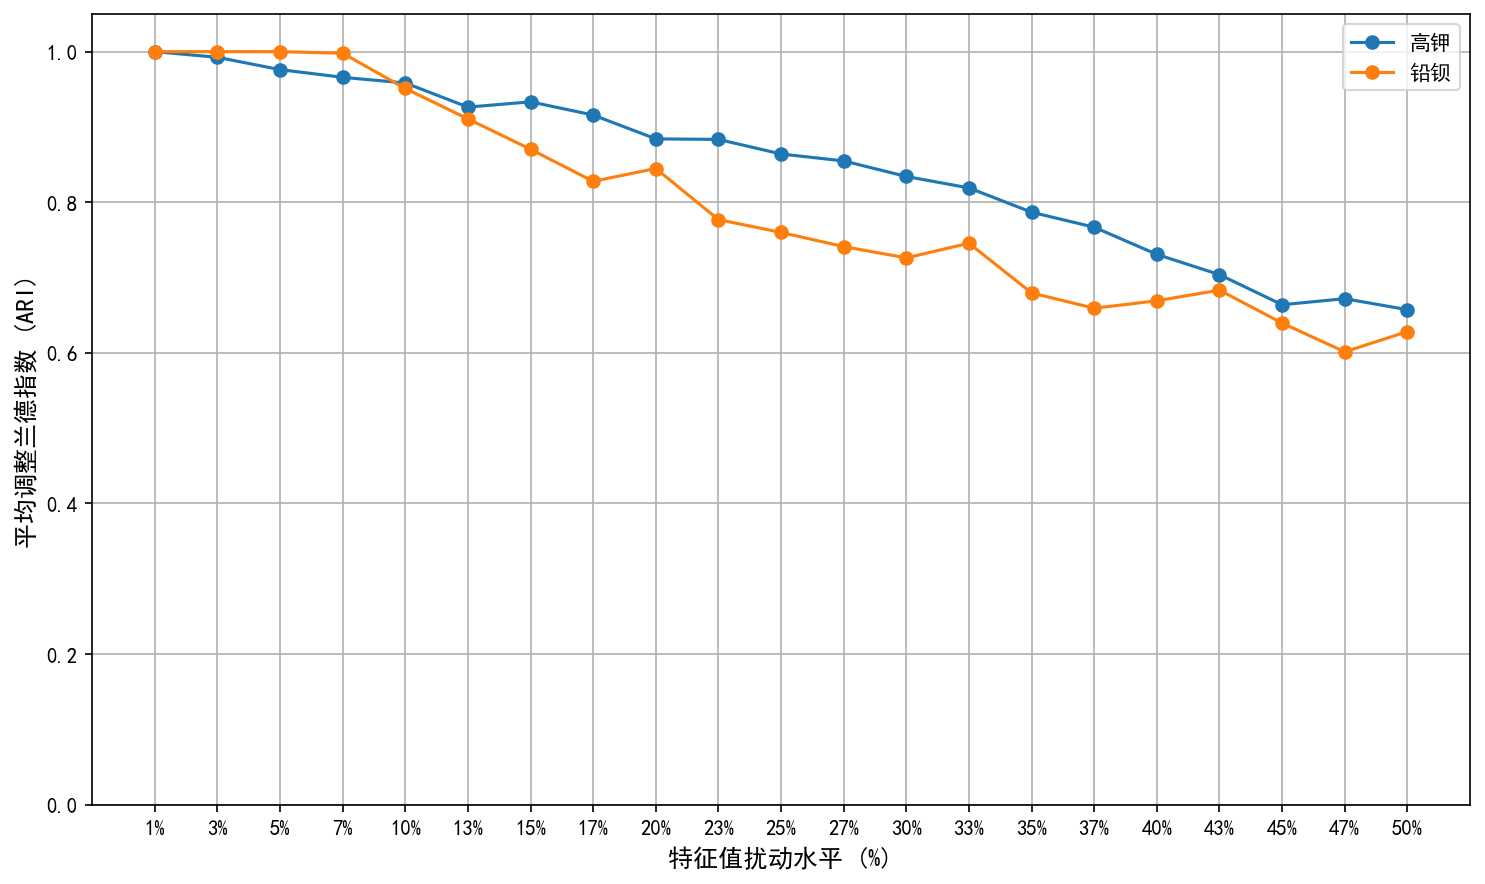

In [12]:
# ==============================================================================
# 灵敏度分析二：特征值扰动法
# ==============================================================================
# 参数定义
NOISE_LEVELS = [0.01, 0.03, 0.05, 0.07, 0.10,0.13,0.15,0.17,0.20,0.23,0.25,0.27,0.30,0.33,0.35,0.37,0.40,0.43,0.45,0.47,0.50] # 扰动水平: 1%, 2%, ..., 10%
N_SIMULATIONS = 500 # 模拟次数

final_ari_results_perturb = {}

print("\n" + "="*60)
print("             灵敏度分析二：特征值扰动法")
print("="*60)

for glass_type, df_clustered_data in all_final_clustered_data.items():
    print(f"\n--- 正在对 {glass_type} 玻璃进行特征值扰动分析 ---")
    
    features = selected_features[glass_type]
    k_clusters = df_clustered_data['亚类'].nunique()
    baseline_labels = df_clustered_data['亚类']
    X_original = df_clustered_data[features]
    
    avg_ari_per_noise_level = []
    
    for noise in NOISE_LEVELS:
        ari_scores_for_current_level = []
        for i in range(N_SIMULATIONS):
            perturbation = 1 + np.random.uniform(-noise, noise, size=X_original.shape)
            X_perturbed = X_original * perturbation
            
            X_perturbed_scaled = StandardScaler().fit_transform(X_perturbed)
            linked_perturbed = linkage(X_perturbed_scaled, method='ward')
            perturbed_labels = fcluster(linked_perturbed, k_clusters, criterion='maxclust')
            
            if len(np.unique(perturbed_labels)) < 2: continue
            score = adjusted_rand_score(baseline_labels, perturbed_labels)
            ari_scores_for_current_level.append(score)
            
        avg_ari = np.mean(ari_scores_for_current_level) if ari_scores_for_current_level else 0
        avg_ari_per_noise_level.append(avg_ari)
        print(f"扰动水平: +/- {noise:.0%}, 平均ARI: {avg_ari:.4f}")
        
    final_ari_results_perturb[glass_type] = avg_ari_per_noise_level

# 可视化结果 (折线图)
plt.figure(figsize=(10, 6))
for glass_type, avg_scores in final_ari_results_perturb.items():
    plt.plot([f'{n*100:.0f}%' for n in NOISE_LEVELS], avg_scores, marker='o', linestyle='-', label=glass_type)


plt.xlabel('特征值扰动水平 (%)', fontsize=12)
plt.ylabel('平均调整兰德指数 (ARI)', fontsize=12)
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.tight_layout()
sensitivity_plot_path = output_dir / '灵敏度分析_特征扰动法.png'
plt.savefig(sensitivity_plot_path, dpi=300)

print(f"\n特征值扰动灵敏度分析折线图已保存。")
plt.show()

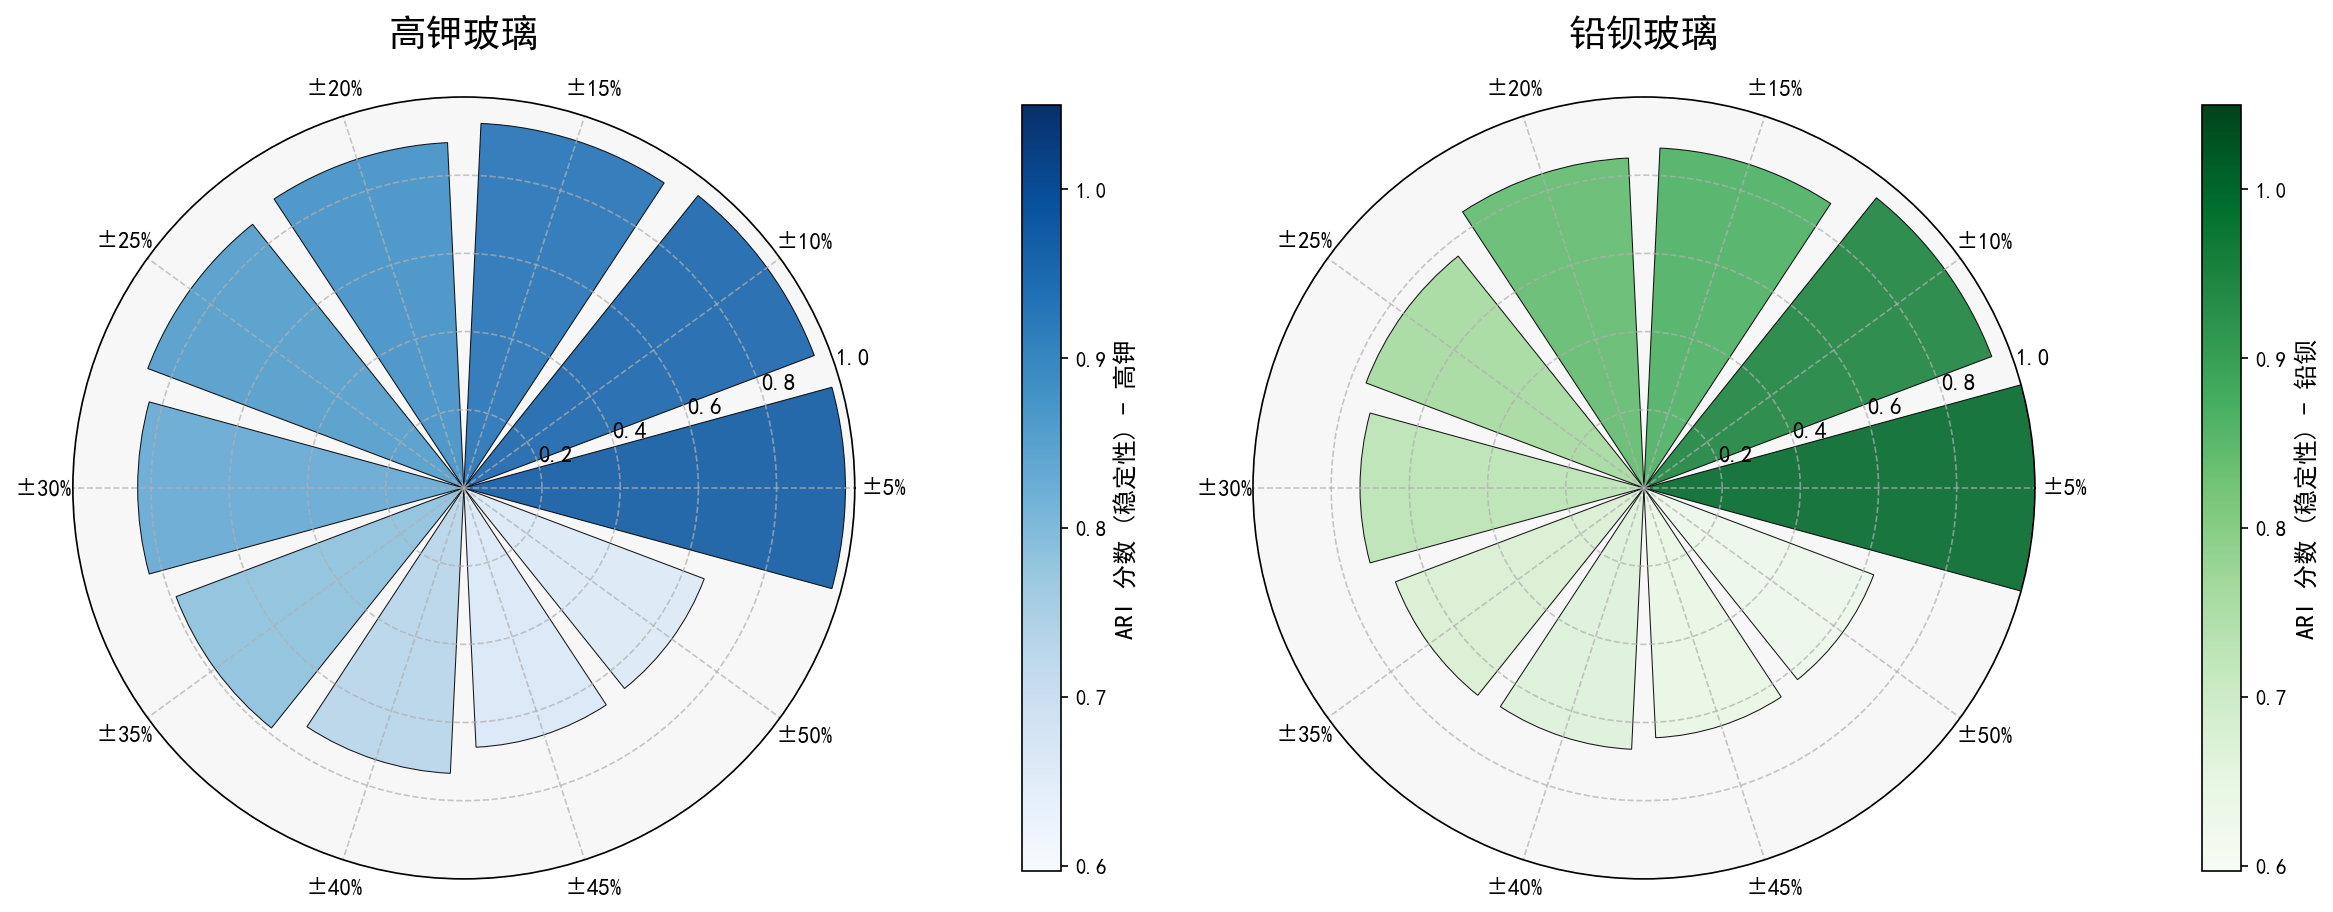


颜色与准确率关联的玫瑰图已保存至: Result\灵敏度分析_玫瑰图_ARI颜色映射.png


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors

# ==============================================================================
# 环境配置
# ==============================================================================
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

# 假设 output_dir 变量已在您的环境中定义
if 'output_dir' not in locals():
    output_dir = Path('../../Result/问题二_最终方案')
    output_dir.mkdir(parents=True, exist_ok=True)

# ==============================================================================
# 1. 准备数据
# ==============================================================================
# 数据列表只包含我们将要绘制的10个数据点
data = {
    '扰动水平': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    '高钾_ARI': [0.9761, 0.9584, 0.9334, 0.8842, 0.8641, 0.8342, 0.7868, 0.7308, 0.6639, 0.6574],
    '铅钡_ARI': [1.0000, 0.9511, 0.8703, 0.8448, 0.7599, 0.7262, 0.6796, 0.6692, 0.6396, 0.6283]
}
df_plot = pd.DataFrame(data)

# ==============================================================================
# 2. 绘制玫瑰图
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))
glass_types = ['高钾', '铅钡']
colormaps = {'高钾': plt.cm.Blues, '铅钡': plt.cm.Greens}

# 【核心修正1】: 创建一个基于ARI分数范围的归一化工具
# 我们将所有ARI分数的最小值和最大值作为颜色映射的范围
all_ari_values = df_plot[['高钾_ARI', '铅钡_ARI']].values.flatten()
norm = mcolors.Normalize(vmin=all_ari_values.min() * 0.95, vmax=all_ari_values.max() * 1.05)


for ax, glass_type in zip(axes, glass_types):
    
    ari_values = df_plot[f'{glass_type}_ARI']
    perturb_levels = df_plot['扰动水平']
    labels = [f'±{level}%' for level in perturb_levels]
    
    N = len(ari_values)
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    width = (2 * np.pi) / N * 0.85
    
    # 【核心修正2】: 使用ARI分数来决定颜色
    colors = colormaps[glass_type](norm(ari_values.values))
    
    bars = ax.bar(theta, ari_values, width=width, alpha=0.9, color=colors, edgecolor='k', linewidth=0.5)
    
    # --- 设置图像样式 ---
    ax.set_ylim(0, 1.0) # 确保从圆心开始
    ax.set_xticks(theta)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_rlabel_position(18)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="black", size=11)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_facecolor('#f7f7f7')
    ax.set_title(f'{glass_type}玻璃', fontsize=18, pad=25)

# --- 【核心修正3】: 修改颜色条以反映ARI分数 ---
sm_blues = plt.cm.ScalarMappable(cmap=colormaps['高钾'], norm=norm)
cbar = fig.colorbar(sm_blues, ax=axes[0], orientation='vertical', pad=0.15, shrink=0.7)
cbar.set_label('ARI 分数 (稳定性) - 高钾', size=12)

sm_greens = plt.cm.ScalarMappable(cmap=colormaps['铅钡'], norm=norm)
cbar2 = fig.colorbar(sm_greens, ax=axes[1], orientation='vertical', pad=0.15, shrink=0.7)
cbar2.set_label('ARI 分数 (稳定性) - 铅钡', size=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
rose_plot_path = output_dir / '灵敏度分析_玫瑰图_ARI颜色映射.png'
plt.savefig(rose_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n颜色与准确率关联的玫瑰图已保存至: {rose_plot_path}")